# Magic Personality Matcher

## Grupo Onyrix

> Mario Vila Comesaña, Jesús Guimeráns Cordeiro, Javier Veloso Boubeta y Tania Guijarro Villavicencio

En este notebook se realiza un estudio sobre cuál sería el clasificador de Scikit-Learn más adecuado para nuestro proyecto.

> Este notebook lo hicimos previo a el notebook final y contiene código que no puede ser fácilmente reproducible, ya que depende de otros notebooks para preprocesado que recompilamos en el definitivo, pero queríamos aprovechar estos resultados, que usamos para realizar el notebook final.

# Estudio de precisión de distintos clasificadores

En este estudio queremos probar distintos clasificadores, de los que usaremos sus parámetros por defecto, ya que hacer hiperparámetros de cada uno llevaría mucho tiempo y ver cuál obtiene el mejor resultado.

Primero importamos los datos de entrenamiento que usaremos para probar los distintos modelos.

# Preprocesado

Primero se carga el dataset y se selecciona la información a usar, como este es un estudio usaremos 10.000 datos como muestra.

In [ ]:
import joblib as jb

preprocessedData = jb.load("preprocessed_data.lzma")

preprocessedData = preprocessedData.head(10_000)

print(preprocessedData.value_counts())

personality  processed_text                              
4                                                            300
8                                                            270
16                                                            84
8            ye                                               14
4            ye                                               12
                                                            ... 
             real                                              1
             readi will abl skip hybe edu workout danc         1
             read wrong fuck                                   1
             read stupid doctor want put                       1
16           yup zhongli sorri drop u man oh god aaaaaaaa      1
Name: count, Length: 8886, dtype: int64


Ahora dividimos el dataset en 60% train, 20% validation y 20% test.

In [ ]:
from sklearn.model_selection import train_test_split

X = preprocessedData['processed_text']
Y = preprocessedData['personality']

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X, Y, test_size=0.25, random_state=42)


Creamos la bolsa de palabras usando solo `X_train` para el TF-IDF.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Datos de entrenamiento
bagOfWordsModel = TfidfVectorizer()
X_train = bagOfWordsModel.fit_transform(X_train)
print("X_train bag of words:")
print(X_train.shape)

# Datos de validación
X_val = bagOfWordsModel.transform(X_val)
print("X_val bag of words:")
print(X_val.shape)

# Datos pruebas
X_test = bagOfWordsModel.transform(X_test)
print("X_test bag of words:")
print(X_test.shape)

X_train bag of words:
(7500, 8470)
X_val bag of words:
(2500, 8470)
X_test bag of words:
(2000, 8470)


Hacemos una reducción de dimensionalidad a 1000 componentes.

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2000, n_oversamples=15, random_state=42)
X_train = svd.fit_transform(X_train)
X_val = svd.transform(X_val)
X_test = svd.transform(X_test)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(7500, 2000)
(2500, 2000)
(2000, 2000)


# Entrenamiento de modelos con datos de prueba

En este caso se usan los datos de `X_train` y `X_val` para determinar cuál es el mejor modelo y probar ciertos parámetros.

Definimos una tupla llamada 'clasificadores' que contiene la información sobre varios clasificadores de ensamble y los parámetros que se probarán con cada uno. Estos clasificadores se utilizan más adelante para realizar pruebas y encontrar mejores parámetros mediante GridSearchCV.

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier

clasificadores = (
    (
        'RandomForest',
        RandomForestClassifier(n_jobs=4),
        {
            'n_estimators': (100,150,200)
        }
    ),
    (
        'GradientBoosting',
        GradientBoostingClassifier(),
        {
            'n_estimators': (100,150,200)
        }
    ),
    (
        'AdaBoost',
        AdaBoostClassifier(),
        {
            'n_estimators': (100,150,200)
        }
    ),
    (
        'HistGradientBoosting',
        HistGradientBoostingClassifier(),
        {
            'max_iter': (100,500,1000)
        }
    )
)

Realizamos la evaluación de varios modelos de clasificación utilizando GridSearchCV para encontrar los mejores hiperparámetros.  Los resultados, que incluyen información sobre el rendimiento de cada modelo, se almacenan en una lista llamada scores y se imprimen al final del bloque.

In [ ]:
from tqdm.contrib.concurrent import process_map
from multiprocessing import Manager
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

scores = Manager().list()

def test_model(data):
    model_name, model, params = data
    gs = GridSearchCV(model, params, cv=5, scoring='accuracy')
    gs.fit(X_train, y_train)

    y_pred = gs.predict(X_val)
    report = classification_report(y_val, y_pred, output_dict=True)
    cm = confusion_matrix(y_val, y_pred)

    scores.append({
        'modelo': model_name,
        'params': gs.best_params_,
        'score': gs.best_score_,
        'confusion_matrix': cm,
        'stats': {
            'precision': report['weighted avg']['precision'],
            'recall': report['weighted avg']['recall'],
            'f1_score': report['weighted avg']['f1-score'],
            'accuracy': report['accuracy']
        }
        })


process_map(test_model, clasificadores)
print(scores)

  0%|          | 0/4 [00:00<?, ?it/s]

[{'modelo': 'RandomForest', 'params': {'n_estimators': 150}, 'score': 0.5461333333333334, 'confusion_matrix': array([[1036,  225,    3],
       [ 674,  410,    6],
       [ 106,   35,    5]]), 'stats': {'precision': 0.5761001174116829, 'recall': 0.5804, 'f1_score': 0.5469172727272728, 'accuracy': 0.5804}}, {'modelo': 'HistGradientBoosting', 'params': {'max_iter': 1000}, 'score': 0.5651999999999999, 'confusion_matrix': array([[897, 360,   7],
       [505, 569,  16],
       [ 83,  56,   7]]), 'stats': {'precision': 0.5708914238835051, 'recall': 0.5892, 'f1_score': 0.5737176011748969, 'accuracy': 0.5892}}, {'modelo': 'AdaBoost', 'params': {'n_estimators': 150}, 'score': 0.4993333333333334, 'confusion_matrix': array([[853, 385,  26],
       [633, 441,  16],
       [ 89,  49,   8]]), 'stats': {'precision': 0.5029145396825396, 'recall': 0.5208, 'f1_score': 0.5042911465779346, 'accuracy': 0.5208}}, {'modelo': 'GradientBoosting', 'params': {'n_estimators': 200}, 'score': 0.5529333333333334, 'c

# Estudio de los resultados

Utilizamos Matplotlib para crear gráficos de barras que comparan los puntajes de diferents modelos(score, f1 score, recall, acuracy). Se resalta el modelo con el puntaje más alto en naranja, que en los tres primeros(score, f1 score y recall) es HistGradientBoosting, excepto en el último(acuracy) que es RandomForest. La visualización ofrece una rápida comparación del rendimiento entre los modelos evaluados.





['RandomForest', 'HistGradientBoosting', 'AdaBoost', 'GradientBoosting']


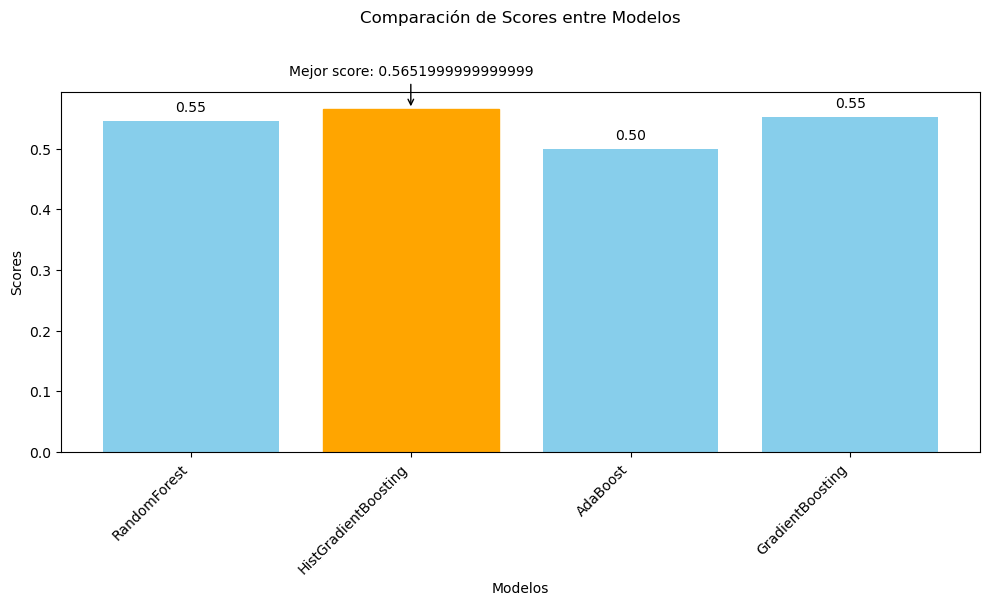

In [ ]:
import matplotlib.pyplot as plt


print([x['modelo'] for x in scores])

plt.figure(figsize=(10, 6))

# Obtener el modelo con el score más alto
mejor_modelo = max(scores, key=lambda x: x['score'])

bars = plt.bar([x['modelo'] for x in scores], [x['score'] for x in scores], color='skyblue')
indice_mejor_modelo = [x['modelo'] for x in scores].index(mejor_modelo['modelo'])
bars[indice_mejor_modelo].set_color('orange')

plt.xlabel('Modelos')
plt.ylabel('Scores')
plt.title('Comparación de Scores entre Modelos', pad=50)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for i, score in enumerate([x['score'] for x in scores]):
    if i != indice_mejor_modelo:
        plt.text(i, score + 0.01, f'{score:.2f}', ha='center', va='bottom')

# Agregar anotación para el score más alto
plt.annotate(f"Mejor score: {mejor_modelo['score']}",
             xy=(indice_mejor_modelo, mejor_modelo['score']),
             xytext=(indice_mejor_modelo, mejor_modelo['score'] + 0.05),
             ha='center', va='bottom',
             arrowprops=dict(facecolor='black', arrowstyle='->'))

# Ajustar los márgenes del gráfico
plt.subplots_adjust(top=0.85, bottom=0.25)  # Puedes ajustar estos valores según tus necesidades

plt.show()



[0.5469172727272728, 0.5737176011748969, 0.5042911465779346, 0.5688931709424151]


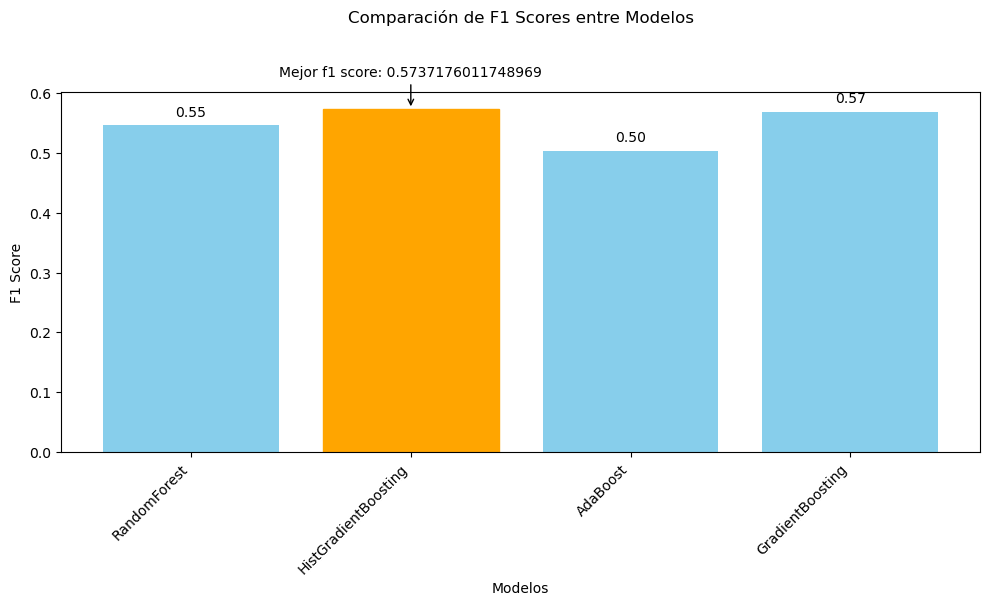

In [ ]:
import matplotlib.pyplot as plt


print([x['stats']['f1_score']  for x in scores])

plt.figure(figsize=(10, 6))

# Obtener el modelo con el score más alto
mejor_modelo = max(scores, key=lambda x: x['stats']['f1_score'] )

bars = plt.bar([x['modelo'] for x in scores], [x['stats']['f1_score'] for x in scores], color='skyblue')
indice_mejor_modelo = [x['modelo'] for x in scores].index(mejor_modelo['modelo'])
bars[indice_mejor_modelo].set_color('orange')

plt.xlabel('Modelos')
plt.ylabel('F1 Score')
plt.title('Comparación de F1 Scores entre Modelos', pad=50)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for i, score in enumerate([x['stats']['f1_score'] for x in scores]):
    if i != indice_mejor_modelo:
        plt.text(i, score + 0.01, f'{score:.2f}', ha='center', va='bottom')

# Agregar anotación para el score más alto
plt.annotate(f"Mejor f1 score: {mejor_modelo['stats']['f1_score'] }",
             xy=(indice_mejor_modelo, mejor_modelo['stats']['f1_score'] ),
             xytext=(indice_mejor_modelo, mejor_modelo['stats']['f1_score']  + 0.05),
             ha='center', va='bottom',
             arrowprops=dict(facecolor='black', arrowstyle='->'))

# Ajustar los márgenes del gráfico
plt.subplots_adjust(top=0.85, bottom=0.25)  # Puedes ajustar estos valores según tus necesidades

plt.show()



[0.5804, 0.5892, 0.5208, 0.5876]


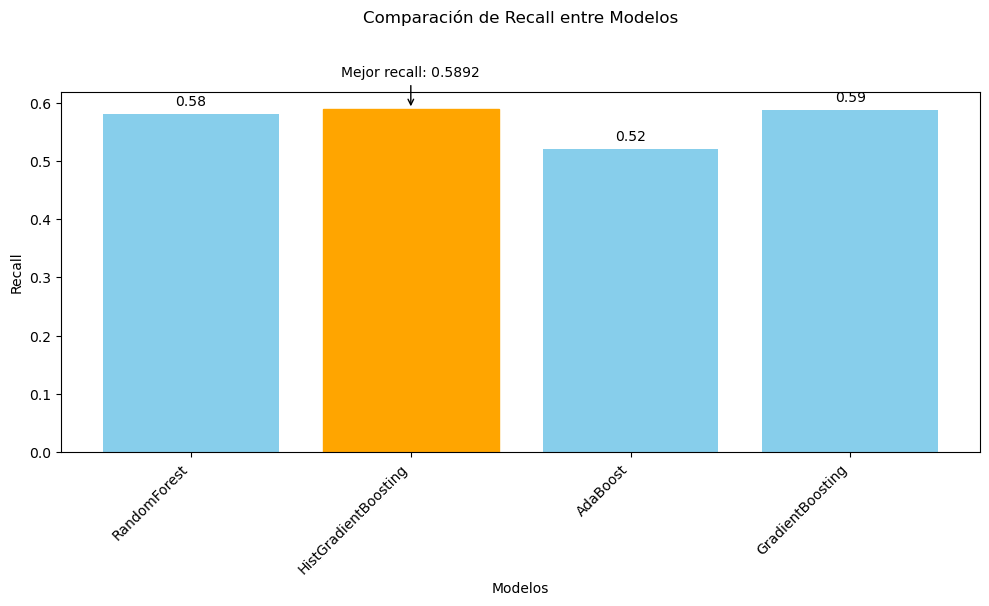

In [ ]:
import matplotlib.pyplot as plt


print([x['stats']['recall']  for x in scores])

plt.figure(figsize=(10, 6))

# Obtener el modelo con el score más alto
mejor_modelo = max(scores, key=lambda x: x['stats']['recall'] )

bars = plt.bar([x['modelo'] for x in scores], [x['stats']['recall'] for x in scores], color='skyblue')
indice_mejor_modelo = [x['modelo'] for x in scores].index(mejor_modelo['modelo'])
bars[indice_mejor_modelo].set_color('orange')

plt.xlabel('Modelos')
plt.ylabel('Recall')
plt.title('Comparación de Recall entre Modelos', pad=50)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for i, score in enumerate([x['stats']['recall'] for x in scores]):
    if i != indice_mejor_modelo:
        plt.text(i, score + 0.01, f'{score:.2f}', ha='center', va='bottom')

# Agregar anotación para el score más alto
plt.annotate(f"Mejor recall: {mejor_modelo['stats']['recall'] }",
             xy=(indice_mejor_modelo, mejor_modelo['stats']['recall'] ),
             xytext=(indice_mejor_modelo, mejor_modelo['stats']['recall']  + 0.05),
             ha='center', va='bottom',
             arrowprops=dict(facecolor='black', arrowstyle='->'))

# Ajustar los márgenes del gráfico
plt.subplots_adjust(top=0.85, bottom=0.25)  # Puedes ajustar estos valores según tus necesidades

plt.show()



[0.5761001174116829, 0.5708914238835051, 0.5029145396825396, 0.5730031247122317]


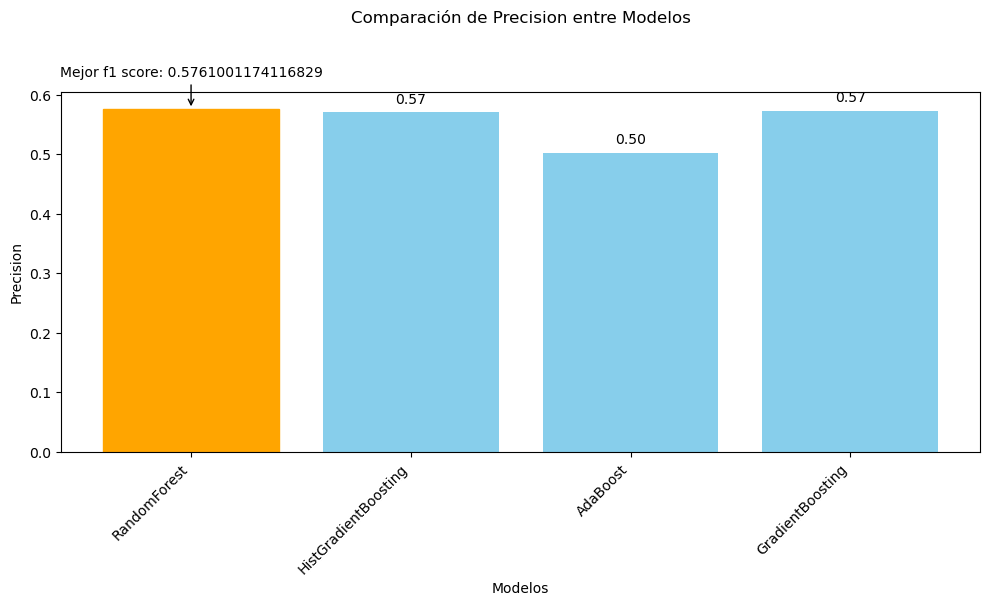

In [ ]:
import matplotlib.pyplot as plt


print([x['stats']['precision']  for x in scores])

plt.figure(figsize=(10, 6))

# Obtener el modelo con el score más alto
mejor_modelo = max(scores, key=lambda x: x['stats']['precision'] )

bars = plt.bar([x['modelo'] for x in scores], [x['stats']['precision'] for x in scores], color='skyblue')
indice_mejor_modelo = [x['modelo'] for x in scores].index(mejor_modelo['modelo'])
bars[indice_mejor_modelo].set_color('orange')

plt.xlabel('Modelos')
plt.ylabel('Precision')
plt.title('Comparación de Precision entre Modelos', pad=50)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for i, score in enumerate([x['stats']['precision'] for x in scores]):
    if i != indice_mejor_modelo:
        plt.text(i, score + 0.01, f'{score:.2f}', ha='center', va='bottom')

# Agregar anotación para el score más alto
plt.annotate(f"Mejor precisión: {mejor_modelo['stats']['precision'] }",
             xy=(indice_mejor_modelo, mejor_modelo['stats']['precision'] ),
             xytext=(indice_mejor_modelo, mejor_modelo['stats']['precision']  + 0.05),
             ha='center', va='bottom',
             arrowprops=dict(facecolor='black', arrowstyle='->'))

# Ajustar los márgenes del gráfico
plt.subplots_adjust(top=0.85, bottom=0.25)  # Puedes ajustar estos valores según tus necesidades

plt.show()



# Matrices de confusión

Mostramos la distribución de clases en el conjunto de validación y generan matrices de confusión para cada modelo en la lista 'scores'. Las matrices de confusión proporcionan información detallada sobre el rendiemiento de los modelos en la clasificación de cada clase.

In [ ]:
y_val.value_counts()

personality
4     1264
8     1090
16     146
Name: count, dtype: int64

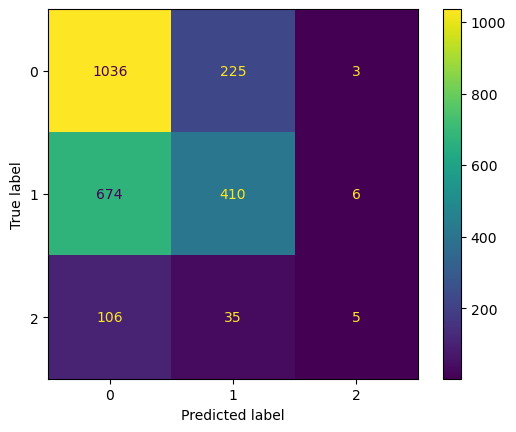

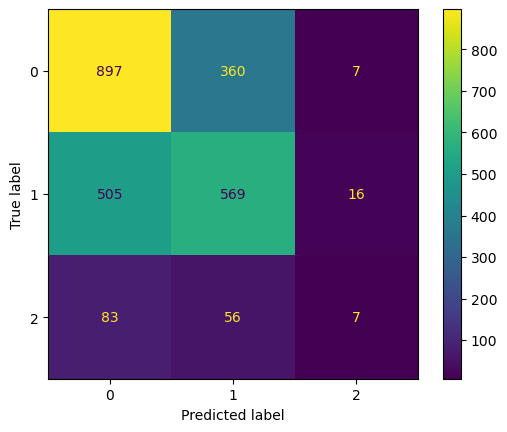

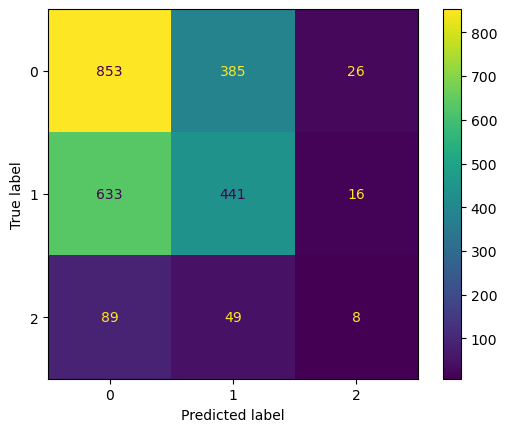

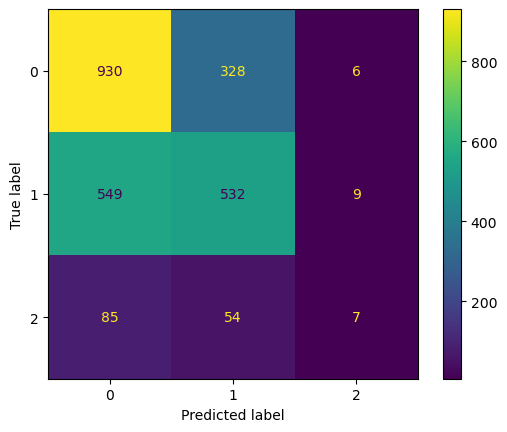

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

for i in scores:
    disp = ConfusionMatrixDisplay(confusion_matrix=i['confusion_matrix'])
    disp.plot()
    plt.show()


# Los mejores parámetros

In [ ]:
print("Mejor modelo:", mejor_modelo['modelo'])
print("Mejores parámetros:", mejor_modelo['params'])

Mejor modelo: RandomForest
Mejores parámetros: {'n_estimators': 150}


Aunque HistGradientBoosting muestra un rendimiento superior en Recall, F1 Score y Score , la métrica empleada para determinar el mejor modelo ha sido Accuracy en el contexto del GridSearchCV. Sin embargo, dado que siempre hay que tener en cuenta el Recall y el F1 Score puesto que aportan información que Accuracy no, reconsideramos la elección del mejor modelo.

Después de revisar los resultados, concluimos que HistGradientBoosting es el modelo preferido, ya que aunque tiene menos Accuracy consigue mejor Recall y F1 Score y es mejor trabajando con grandes cantidades de datos (>10k entradas) como es nuestro caso.

También hemos realizado pruebas ajustando el número de componentes para la reducción de dimensionalidad con Truncated SVD:
- n_components=500: Resultados pobres, todos los modelos con aproximadamente un 18% de precisión.
- n_components=1000: Mejores resultados, todos los modelos alrededor del 56% de precisión.
- n_components=2000: Resultados muy similares a 1000 (58% de precisión), aunque podría ser relevante con un mayor volumen de datos.




# Conclusiones

De este estudio obtenemos que no hay gran diferencia entre el redimiento de los distintos modelos con nuestro problema y dataset. HistGradientBoosting se elige como el clasificador principal, considerando su buen rendimiento en las métricas clave.

Además, se contempla la posibilidad de explorar técnicas de combinación de modelos, como Bagging o Stacking, aunque se reconoce que para lograr efectividad, podríamos requerir modelos de aprendizaje no basados en árboles de decisión, como agrupamiento con K-Means, topic modeling con LDA o redes neuronales.
